<a href="https://colab.research.google.com/github/inuwamobarak/detecting-tables-in-documents/blob/main/Detecting_Table_Rows_and_Columns_in_Images_Using_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table Rows and Columns Detection
Have you had experience dealing with unstructured data and pondered over methods to identify tables within your documents? Perhaps this consideration aimed to facilitate streamlined document processing. Within the scope of this article, we will delve into the process of not only identifying the existence of tables but also comprehending the inherent structure of said tables. This achievement is enabled through the utilization of two discrete models. The first is dedicated to the detection of tables within documents, while the second focuses on the recognition of table structures, effectively discerning individual rows and columns within the tables.

Some Links to check out on 🤗 Table Transformers:

Credits to: [NielsRogge](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb)

https://huggingface.co/docs/transformers/model_doc/detr

https://huggingface.co/docs/transformers/model_doc/table-transformer

https://huggingface.co/microsoft/table-transformer-detection

https://huggingface.co/microsoft/table-transformer-structure-recognition

The URL provided is the GitHub repository of the Hugging Face Transformers library, which is being installed using the git+ syntax.

In [ ]:
# Install the transformers library from the Hugging Face repository
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00


timm is for computer vision and deep learning that will provide us with implementations various training procedures, and utilities.

In [ ]:
# Install the 'timm' library using pip
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.8 MB/s eta 0:00:00


We will first demonstrate table detection. I have added some sample images in my 🤗 Huggingface repository as type dataset. You could use your own image here.

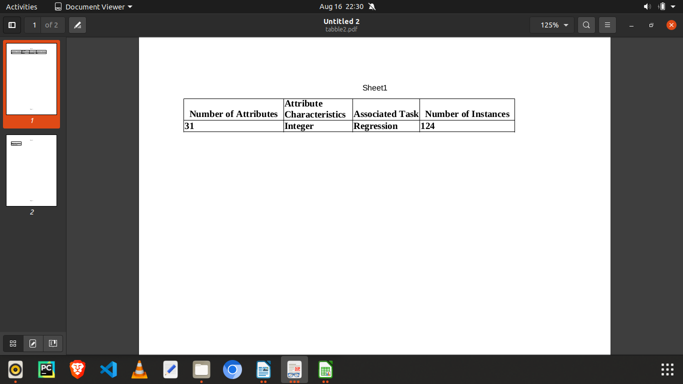

In [ ]:
# Import the necessary libraries
from huggingface_hub import hf_hub_download
from PIL import Image

# Download a file from the specified Hugging Face repository and location
file_path = hf_hub_download(repo_id="inuwamobarak/random-files", repo_type="dataset", filename="Screenshot from 2023-08-16 22-30-54.png")

# Open the downloaded image using the PIL library and convert it to RGB format
image = Image.open(file_path).convert("RGB")

# Get the original width and height of the image
width, height = image.size

# Resize the image to 50% of its original dimensions
resized_image = image.resize((int(width * 0.5), int(height * 0.5)))

Let's first apply the regular image preprocessing using `DetrFeatureExtractor`. The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.

In [ ]:
# Import the DetrFeatureExtractor class from the transformers library
from transformers import DetrFeatureExtractor

# Create an instance of the DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()

# Use the feature extractor to encode the image
encoding = feature_extractor(image, return_tensors="pt")

# Get the keys of the encoding dictionary
keys = encoding.keys()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

The model we are loading is the "microsoft/table-transformer-detection" model. This model is designed to perform object detection tasks specifically on tabular data, such as tables in documents or spreadsheets.

In [ ]:
# Import the TableTransformerForObjectDetection class from the transformers library
from transformers import TableTransformerForObjectDetection

# Load the pre-trained Table Transformer model for object detection
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

We will visualize our image with matplotlib. The function creates a visualization by overlaying rectangles (bounding boxes) on the image to represent the detected objects and adding text annotations with the corresponding label and score.

In [ ]:
import matplotlib.pyplot as plt

# Define colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100

    # Iterate through scores, labels, boxes, and colors for visualization
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        # Add a rectangle to the image for the detected object's bounding box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))

        # Prepare the text for the label and score
        text = f'{model.config.id2label[label]}: {score:0.2f}'

        # Add the label and score text to the image
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()

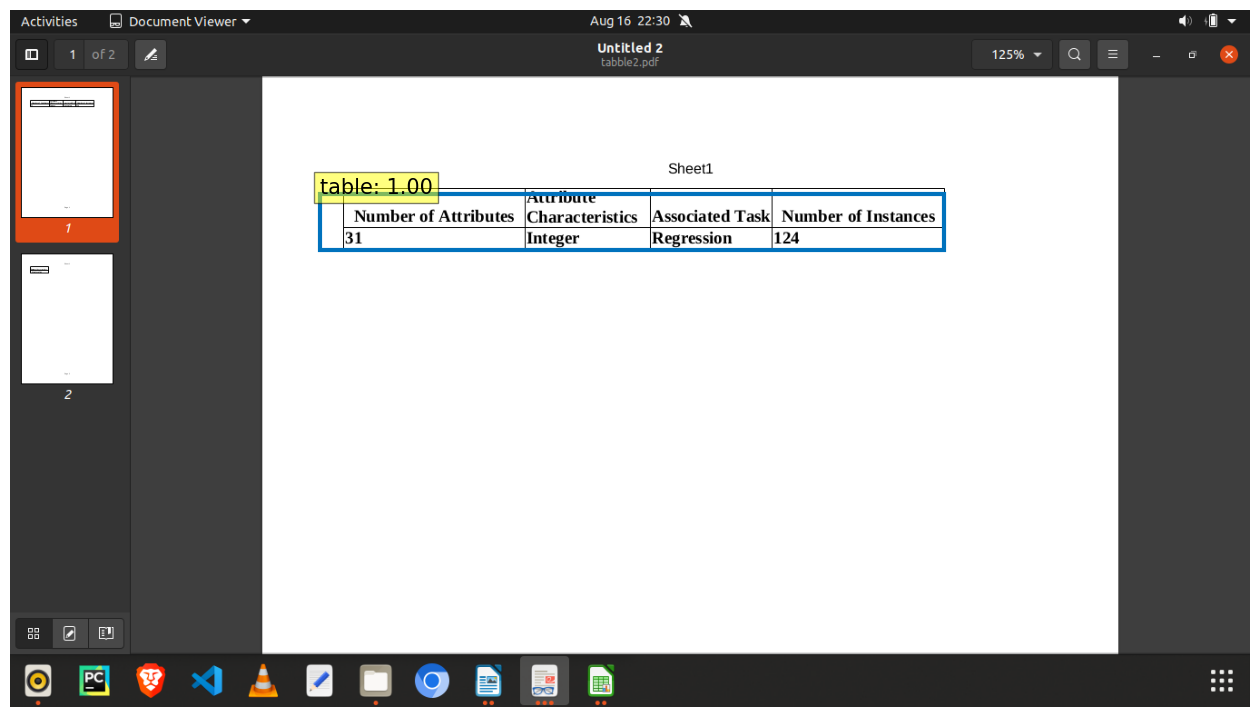

In [ ]:
# Get the original width and height of the image
width, height = image.size

# Post-process the object detection outputs using the feature extractor
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

# Plot the visualization of the results
plot_results(image, results['scores'], results['labels'], results['boxes'])

  This has detected the presence of a table perfectly. We will now try to detect the rows and columns. As noted in the article, two separate approaches were used for this different objectives.

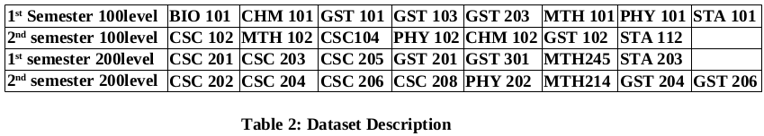

In [ ]:
# Import the necessary libraries
from huggingface_hub import hf_hub_download
from PIL import Image

# Download the image file from the specified Hugging Face repository and location
# Use either of the provided 'repo_id' lines depending on your use case
file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
# file_path = hf_hub_download(repo_id="inuwamobarak/random-files", repo_type="dataset", filename="Screenshot from 2023-08-16 22-40-10.png")

# Open the downloaded image using the PIL library and convert it to RGB format
image = Image.open(file_path).convert("RGB")

# Get the original width and height of the image
width, height = image.size

# Resize the image to 90% of its original dimensions
resized_image = image.resize((int(width * 0.9), int(height * 0.9)))

In [ ]:
# Use the feature extractor to encode the resized image
encoding = feature_extractor(image, return_tensors="pt")

# Get the keys of the encoding dictionary
keys = encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

Let's load the model from the hub, and perform a forward pass.

In [ ]:
# Import the TableTransformerForObjectDetection class from the transformers library
from transformers import TableTransformerForObjectDetection

# Load the pre-trained Table Transformer model for table structure recognition
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

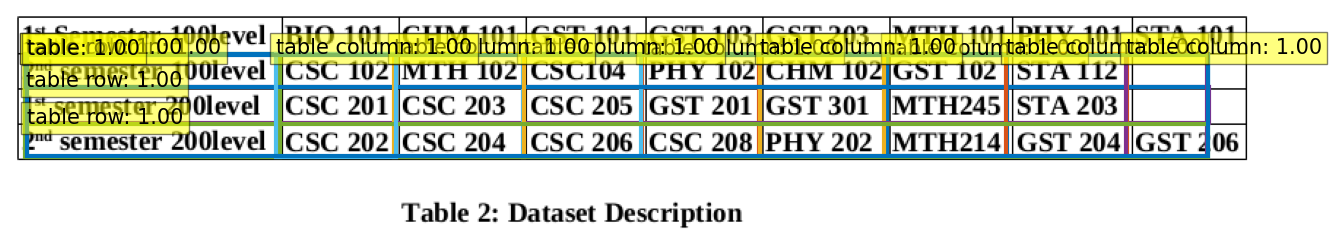

In [ ]:
# Create a list of target sizes for post-processing
# 'image.size[::-1]' swaps the width and height to match the target size format (height, width)
target_sizes = [image.size[::-1]]

# Post-process the object detection outputs using the feature extractor
# Use a threshold of 0.6 for confidence
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

# Plot the visualization of the results
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}